In [1]:
import argparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import numpy as np
import xgboost as xgb
from sklearn.svm import SVC

/home/prachit/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [62]:
def merge_and_sort_csv(file1, file2, output_file):
    # Load the CSV files into pandas DataFrames
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    #df3 = pd.read_csv(file3)

    # Combine the data from both DataFrames
    combined_df = pd.concat([df1, df2], ignore_index=True)

    # Sort the combined data by the 'action' column (ascending order)
    sorted_df = combined_df.sort_values(by='action', ascending=True)

    # Save the sorted data to a new CSV file
    sorted_df.to_csv(output_file, index=False)

    print(f"Data merged and sorted successfully. Saved to {output_file}")

# Example usage
file1 = 'datasets_try/processed_features_ml_cl.csv'  # Path to your first CSV file
file2 = 'datasets_try/processed_features_all_cl.csv'  # Path to your second CSV file
#file3 = 'datasets_try/processed_features_5k.csv'
# file4 = 'datasets_try/processed_features_el.csv' 
output_file = 'datasets_try/collision_free.csv'  # Output CSV file

merge_and_sort_csv(file1, file2, output_file)

##add more datapoints 


Data merged and sorted successfully. Saved to datasets_try/collision_free.csv


In [2]:
# Load the dataset
collision_free_data = pd.read_csv('datasets_try/processed_features_collision_free.csv')

# Check the distribution of the 'action' column
action_distribution = collision_free_data['action'].value_counts()
print(action_distribution)

3.0    2761
4.0    2107
0.0    1605
1.0    1210
2.0      17
Name: action, dtype: int64


UPSAMPLE MINORITY using dataset fromrandomly generated cenarios

In [9]:

# Step 1: Load the dataset from the file
file_path =  'datasets_try/processed_features_all.csv'
#file_path2 = 'datasets_try/processed_features_el_cl.csv'
df = pd.read_csv(file_path)

# Step 2: Sort the dataset by the action label (last column)
# Assuming the action label is the last column
df_sorted = df.sort_values(by='action', ascending=True)

# Step 3: Extract data points with action label 0 and 2
df_label_0 = df_sorted[df_sorted[df.columns[-1]] == 0]
df_label_2 = df_sorted[df_sorted[df.columns[-1]] == 2]

# Step 4: Save the filtered data to separate CSV files
file_label_0 = 'datasets_try/processed_label_0_data.csv'
file_label_2 = 'datasets_try/processed_label_2_data.csv'

df_label_0.to_csv(file_label_0, index=False)
df_label_2.to_csv(file_label_2, index=False)

# Step 5: Extract 200 data points from each new CSV and merge them into another CSV
# Load the previously saved files
df_label_0_loaded = pd.read_csv(file_label_0)
df_label_2_loaded = pd.read_csv(file_label_2)

# Randomly select 200 data points from each
df_label_0_sampled = df_label_0_loaded.sample(n=0, random_state=42)
df_label_2_sampled = df_label_2_loaded.sample(n=59, random_state=42)

# Step 6: Merge the two sampled dataframes
merged_df = pd.concat([df_label_0_sampled, df_label_2_sampled])

# Step 7: Load the existing merged dataset if it exists or create a new one
input_file_path =  'datasets_try/processed_features_collision_free.csv'

try:
    collision_free_data = pd.read_csv(input_file_path)
    # Append the new merged data to the existing one
    collision_free_data_upsampled = pd.concat([collision_free_data, merged_df])
except FileNotFoundError:
    # If the file does not exist, create a new one
    collision_free_data = merged_df

# Step 8: Save the merged data back into the CSV
collision_free_data_upsampled.to_csv('datasets_try/processed_collision_free_upsampled.csv', index=False)

print(f"Successfully processed and saved the data. Merged dataset saved at datasets_try/collision_free_upsampled.csv") 

action_distribution = collision_free_data_upsampled['action'].value_counts()
print(action_distribution)

Successfully processed and saved the data. Merged dataset saved at datasets_try/collision_free_upsampled.csv
3.0    2761
4.0    2107
0.0    1605
1.0    1210
2.0      76
Name: action, dtype: int64


Normal


In [4]:
# Create a binary target variable
collision_free_data_upsampled['binary_target'] = collision_free_data_upsampled['action'].apply(lambda x: 1 if x in [1,3,0, 4] else 0)

# Split the data into features and binary target
X_binary = collision_free_data_upsampled.drop(columns=['action', 'binary_target'])
y_binary = collision_free_data_upsampled['binary_target']

# Split the dataset into train, test, and eval sets
X_train_binary, X_temp_binary, y_train_binary, y_temp_binary = train_test_split(X_binary, y_binary, test_size=0.3, random_state=42)
X_test_binary, X_eval_binary, y_test_binary, y_eval_binary = train_test_split(X_temp_binary, y_temp_binary, test_size=0.5, random_state=42)

# Train the binary classifier
binary_rf_model = RandomForestClassifier(random_state=42)
binary_rf_model.fit(X_train_binary, y_train_binary)

# Evaluate the binary classifier
y_pred_binary_test = binary_rf_model.predict(X_test_binary)
accuracy_binary_test = accuracy_score(y_test_binary, y_pred_binary_test)
print(f"Binary Classifier Accuracy on Test Data: {accuracy_binary_test * 100:.2f}%")
# Calculate precision, recall, and F1-score
precision_test = precision_score(y_test_binary, y_pred_binary_test)
recall_test = recall_score(y_test_binary, y_pred_binary_test)
f1_test = f1_score(y_test_binary, y_pred_binary_test)

# Print metrics
print(f"Precision on Test Data: {precision_test * 100:.2f}%")
print(f"Recall on Test Data: {recall_test * 100:.2f}%")
print(f"F1-Score on Test Data: {f1_test * 100:.2f}%")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary_test))

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_binary_test))

# Save the binary classifier
joblib.dump(binary_rf_model, 'models_try/binary_rf_model_collision_free_upsampled.pkl')
#print(data[5:10])

Binary Classifier Accuracy on Test Data: 99.40%
Precision on Test Data: 99.65%
Recall on Test Data: 99.74%
F1-Score on Test Data: 99.70%

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       1.00      1.00      1.00      1155

    accuracy                           0.99      1164
   macro avg       0.81      0.78      0.79      1164
weighted avg       0.99      0.99      0.99      1164


Confusion Matrix:
[[   5    4]
 [   3 1152]]


['models_try/binary_rf_model_collision_free_upsampled.pkl']

downsampling

In [66]:
collision_free_data_upsampled['binary_target'] = collision_free_data_upsampled['action'].apply(lambda x: 1 if x in [1, 3,4] else 0)

# Separate majority and minority classes
majority_class = collision_free_data_upsampled[collision_free_data_upsampled['binary_target'] == 1]
minority_class = collision_free_data_upsampled[collision_free_data_upsampled['binary_target'] == 0]
idle_class = collision_free_data_upsampled[collision_free_data_upsampled['action'] == 1]
non_ideal_class = collision_free_data_upsampled[collision_free_data_upsampled['action'] != 1]

# Downsample majority class
idle_downsampled = resample(idle_class, 
                                replace=True,    # Sample without replacement
                                n_samples=1500,  # Match minority class size
                                random_state=42)
collision_free_data_up_downsampled = pd.concat([idle_downsampled, non_ideal_class])

print(collision_free_data_up_downsampled['action'].value_counts())

4.0    1567
1.0    1500
3.0    1424
2.0     611
0.0     506
Name: action, dtype: int64


In [ ]:
# Create a binary target variable
collision_free_data_up_downsampled['binary_target'] = collision_free_data_up_downsampled['action'].apply(lambda x: 1 if x in [1,3, 4] else 0)

# Split the data into features and binary target
X_binary = collision_free_data_up_downsampled.drop(columns=['action', 'binary_target'])
y_binary = collision_free_data_up_downsampled['binary_target']

# Split the dataset into train, test, and eval sets
X_train_binary, X_temp_binary, y_train_binary, y_temp_binary = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)
X_test_binary, X_eval_binary, y_test_binary, y_eval_binary = train_test_split(X_temp_binary, y_temp_binary, test_size=0.5, random_state=42)

# Train the binary classifier
binary_rf_model = RandomForestClassifier(random_state=42)
binary_rf_model.fit(X_train_binary, y_train_binary)

# Evaluate the binary classifier
y_pred_binary_test = binary_rf_model.predict(X_test_binary)
accuracy_binary_test = accuracy_score(y_test_binary, y_pred_binary_test)
print(f"Binary Classifier Accuracy on Test Data: {accuracy_binary_test * 100:.2f}%")
# Calculate precision, recall, and F1-score
precision_test = precision_score(y_test_binary, y_pred_binary_test)
recall_test = recall_score(y_test_binary, y_pred_binary_test)
f1_test = f1_score(y_test_binary, y_pred_binary_test)

# Print metrics
print(f"Precision on Test Data: {precision_test * 100:.2f}%")
print(f"Recall on Test Data: {recall_test * 100:.2f}%")
print(f"F1-Score on Test Data: {f1_test * 100:.2f}%")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary_test))

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_binary_test))

# Save the binary classifier
joblib.dump(binary_rf_model, 'models_try/binary_rf_model_collision_free_up_down.pkl')
#print(data[5:10])

xgb

In [ ]:

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train_binary, y_train_binary)

# Make predictions on the test set
y_pred_test = xgb_model.predict(X_test_binary)

# Evaluate the model
accuracy_test = accuracy_score(y_test_binary, y_pred_test)
precision_test = precision_score(y_test_binary, y_pred_test)
recall_test = recall_score(y_test_binary, y_pred_test)
f1_test = f1_score(y_test_binary, y_pred_test)

print(f"XGBoost Accuracy on Test Data: {accuracy_test * 100:.2f}%")
print(f"Precision on Test Data: {precision_test * 100:.2f}%")
print(f"Recall on Test Data: {recall_test * 100:.2f}%")
print(f"F1-Score on Test Data: {f1_test * 100:.2f}%")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_test))

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_test))

# Save the trained XGBoost model
joblib.dump(xgb_model, 'models_try/xgb_model.pkl')

svm

In [ ]:
# Initialize the SVM classifier
svm_model = SVC(kernel='rbf', random_state=42)  # Using radial basis function kernel

# Train the model
svm_model.fit(X_train_binary, y_train_binary)

# Make predictions on the test set
y_pred_test = svm_model.predict(X_test_binary)

# Evaluate the model
accuracy_test = accuracy_score(y_test_binary, y_pred_test)
precision_test = precision_score(y_test_binary, y_pred_test)
recall_test = recall_score(y_test_binary, y_pred_test)
f1_test = f1_score(y_test_binary, y_pred_test)

print(f"svm Accuracy on Test Data: {accuracy_test * 100:.2f}%")
print(f"Precision on Test Data: {precision_test * 100:.2f}%")
print(f"Recall on Test Data: {recall_test * 100:.2f}%")
print(f"F1-Score on Test Data: {f1_test * 100:.2f}%")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_test))

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_test))

# Save the trained XGBoost model
joblib.dump(xgb_model, 'models_try/xgb_model.pkl')

class  weights

In [68]:
##using inverse frequency method

class_weights = {
    1: 1,     # Majority class 1
    4: 1,     # Majority class 4
    0: 3,     # Minority class 0
    2: 2.5,   # Minority class 2
    3: 2      # Minority class 3
}


class_weights_binary = {
    0: 17,     # Minority class 
    1: 1,     # Majority class 
}

In [ ]:
# Create binary target variable
collision_free_data_upsampled['binary_target'] = collision_free_data_upsampled['action'].apply(lambda x: 1 if x in [1,3, 4] else 0)

# Split the data into features and target
X_binary = collision_free_data_upsampled.drop(columns=['action', 'binary_target'])
y_binary = collision_free_data_upsampled['binary_target']

# Split the dataset into train, test, and eval sets
X_train_binary, X_temp_binary, y_train_binary, y_temp_binary = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)
X_test_binary, X_eval_binary, y_test_binary, y_eval_binary = train_test_split(X_temp_binary, y_temp_binary, test_size=0.5, random_state=42)

# Train the binary classifier with class weights
binary_rf_model = RandomForestClassifier(class_weight=class_weights_binary, random_state=42)
binary_rf_model.fit(X_train_binary, y_train_binary)

# Evaluate the binary classifier
y_pred_binary_test = binary_rf_model.predict(X_test_binary)
accuracy_binary_test = accuracy_score(y_test_binary, y_pred_binary_test)
print(f"Binary Classifier Accuracy on Test Data: {accuracy_binary_test * 100:.2f}%")
print(f"Precision on Test Data: {precision_test * 100:.2f}%")
print(f"Recall on Test Data: {recall_test * 100:.2f}%")
print(f"F1-Score on Test Data: {f1_test * 100:.2f}%")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary_test))

# Generate a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_binary_test))

# Save the binary classifier
joblib.dump(binary_rf_model, 'models_try/binary_rf_model_weights.pkl')

minor action classifier

In [ ]:
# Filter the data for classes 0, 2,
minor_data = collision_free_data_upsampled[collision_free_data_upsampled['binary_target'] == 0]
#print(filtered_data[0:5])

# Split the dataset into features and target
X = minor_data.drop(columns=['action', 'binary_target'])
y = minor_data['action']  # Multi-class target

# Split into train, test, and eval sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train a single Random Forest classifier
rf_model_minor = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_minor.fit(X_train, y_train)

# Make predictions
y_pred_test = rf_model_minor.predict(X_test)
y_pred_eval = rf_model_minor.predict(X_eval)

# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Evaluation Accuracy:", accuracy_score(y_eval, y_pred_eval))
print("\nClassification Report on Test Data:\n", classification_report(y_test, y_pred_test))

# Save the binary classifier
joblib.dump(rf_model_minor, 'models_try/minor_rf_model_upsampled.pkl')


major action classifier

In [ ]:
##using all data for 1-3-4

In [26]:
import pandas as pd
def filter_data(file_path, labels_to_extract):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Check if the 'action' column exists
    if 'action' not in df.columns:
        raise ValueError(f"The 'action' column is missing in the file: {file_path}")
    
    # Filter the dataframe based on the action label
    filtered_df = df[df['action'].isin(labels_to_extract)]
    return filtered_df

# Function to process multiple CSV files and merge the data
def process_datasets(file_paths, labels_to_extract):
    all_filtered_data = []
    
    # Process each dataset
    for file_path in file_paths:
        filtered_data = filter_data(file_path, labels_to_extract)
        all_filtered_data.append(filtered_data)
    
    # Combine all the filtered data into a single dataframe
    combined_data = pd.concat(all_filtered_data, ignore_index=True)
    return combined_data

# List of file paths (you can add/remove paths as needed)
file_paths = [
      # Add paths to your CSV files
    #'datasets_try/processed_features_collision_free.csv',
    'datasets_try/processed_features_all.csv',
    # 'datasets_try/processed_features_el_cl.csv'
    # 'dataset4.csv',
    # 'dataset5.csv'
]

# Define labels to extract
labels_to_extract = [1, 3,0, 4]

# Process the datasets and create the new dataset
new_dataset = process_datasets(file_paths, labels_to_extract)

# Save the new dataset to a CSV file
new_dataset.to_csv('datasets_try/processed_major.csv', index=False)

print("filtered dataset saved as 'filtered_dataset.csv'.")


filtered dataset saved as 'filtered_dataset.csv'.


In [27]:
# Load the dataset
major_data = pd.read_csv('datasets_try/processed_major.csv')

# Check the distribution of the 'action' column
action_distribution =major_data['action'].value_counts()
print(action_distribution)

3.0    5111
4.0    3735
0.0    2689
1.0    2251
Name: action, dtype: int64


In [35]:
slow_class = major_data[major_data['action'] == 4]
idle_class = major_data[major_data['action'] == 1]
fast_class =major_data[major_data['action'] == 3]
left_class =major_data[major_data['action'] == 0]

# Downsample majority class
idle_downsampled = resample(idle_class, 
                                replace=True,    # Sample without replacement
                                n_samples=2251,  # Match minority class size
                                random_state=42)
slow_downsampled = resample(slow_class, 
                                replace=True,    # Sample without replacement
                                n_samples=3000,  # Match minority class size
                                random_state=42)

fast_downsampled = resample(fast_class, 
                                replace=True,    # Sample without replacement
                                n_samples=3000,  # Match minority class size
                                random_state=42)
                        
left_downsampled = resample(left_class, 
                                replace=True,    # Sample without replacement
                                n_samples=2689,  # Match minority class size
                                random_state=42)
major_downsampled = pd.concat([idle_downsampled, slow_downsampled, fast_downsampled,left_downsampled])

print(major_downsampled['action'].value_counts())

4.0    3000
3.0    3000
0.0    2689
1.0    2251
Name: action, dtype: int64


In [43]:
# # Filter the data for classes 1 3and 4
# major_data_down_upsampled = collision_free_data_up_downsampled[collision_free_data_up_downsampled['binary_target'] == 1]
# #print(filtered_data[0:5])

# Split the dataset into features and target
# X = new_dataset.drop(columns=['action', 'binary_target'])
X = major_downsampled.drop(columns=['action'])
y = major_downsampled['action']  # Multi-class target

# Split into train, test, and eval sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train a single Random Forest classifier
rf_model_major = RandomForestClassifier(class_weight  = 'balanced', bootstrap= True, max_depth= 20, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200)

rf_model_major.fit(X_train, y_train)

# Make predictions
y_pred_test = rf_model_major.predict(X_test)
y_pred_eval = rf_model_major.predict(X_eval)

# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Evaluation Accuracy:", accuracy_score(y_eval, y_pred_eval))
print("\nClassification Report on Test Data:\n", classification_report(y_test, y_pred_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

# Save the binary classifier
joblib.dump(rf_model_major, 'models_try/major_rf_model_down_upsampled.pkl')


Test Accuracy: 0.7221206581352834
Evaluation Accuracy: 0.7221206581352834

Classification Report on Test Data:
               precision    recall  f1-score   support

         0.0       0.71      0.77      0.74       133
         1.0       0.72      0.69      0.70       118
         3.0       0.66      0.66      0.66       132
         4.0       0.79      0.76      0.77       164

    accuracy                           0.72       547
   macro avg       0.72      0.72      0.72       547
weighted avg       0.72      0.72      0.72       547


Confusion Matrix:
[[102   6  12  13]
 [ 13  81  17   7]
 [ 15  16  87  14]
 [ 13  10  16 125]]


['models_try/major_rf_model_down_upsampled.pkl']

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_s

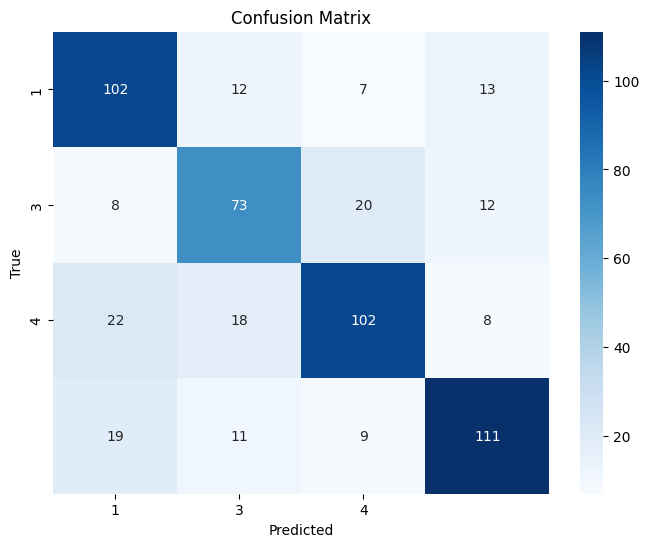

['models_try/major_rf_model_tuned.pkl']

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# Split the dataset into features and target
X = major_downsampled.drop(columns=['action'])
y = major_downsampled['action']  # Multi-class target

# Train-Test-Eval split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Set up Random Forest with class weight balanced to handle imbalance
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Set up Grid Search parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV to find the best model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred_test = best_rf.predict(X_test)
y_pred_eval = best_rf.predict(X_eval)

# Performance Evaluation
print("\nTest Accuracy:", accuracy_score(y_test, y_pred_test))
print("Evaluation Accuracy:", accuracy_score(y_eval, y_pred_eval))

print("\nClassification Report on Test Data:\n", classification_report(y_test, y_pred_test))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[1,3,4], yticklabels=[1,3,4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model
joblib.dump(best_rf, 'models_try/major_rf_model_tuned.pkl')